# 2c Simulation Adding more Features
Prepare Imports & Paths:

In [1]:
import matplotlib.pyplot as plt
from scipy.stats import chi2
import numpy as np
import pandas as pd
import seaborn as sns
from julearn import run_cross_validation
from sklearn.model_selection import RepeatedKFold
import matplotlib as mpl
from leakconfound.plotting import mm_to_inch
from leakconfound.transformers import Shuffle
from sciplotlib import style
from pathlib import Path

from leakconfound.analyses.utils import save_paper_val

import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

base_save_paper = "./paper_val/"

increase_features_extra_save_paper = "./paper_val/increase_features_extra/"
Path(increase_features_extra_save_paper).mkdir(parents=True, exist_ok=True)

mpl.style.use(style.get_style("nature-reviews"))
mpl.rc("xtick", labelsize=11)
mpl.rc("ytick", labelsize=11)
mpl.rc("axes", labelsize=12, titlesize=12)
mpl.rc("figure", dpi=300)
mpl.rc("figure.subplot", wspace=mm_to_inch(4), hspace=mm_to_inch(7))
mpl.rc("lines", linewidth=1)

colors = [
    "#E64B35",
    "#4DBBD5",
    "#00A087",
    "#3C5488",
    "#F39B7F",
    "#8491B4",
    "#91D1C2FF",
    "#DC0000",
    "#7E6148",
    "#B09C85",
]
red = colors[0]
blue = colors[1]
green = colors[2]
purple = colors[5]

Simulate Data:

In [2]:
np.random.seed(7329847)

confound = np.array([0] * 1000 + [1] * 1000)
target = np.random.normal(scale=0.2, size=2000) + confound
n_feat = 1

all_scores_rem = []
all_yerr_rem = []
all_scores_raw = []
all_yerr_raw = []

np.random.seed(78901234)

feat_nbr = [1, *list(range(10, 101, 10))]
for i in feat_nbr:
    n_feat = i
    feat = np.append(
        chi2.rvs(df=3, scale=0.5, size=[1000, n_feat]),
        chi2.rvs(df=4, size=[1000, n_feat]),
        axis=0,
    )
    X = [f"feat_{ii}" for ii in range(n_feat)]
    df = pd.DataFrame(feat, columns=X)

    df[X] = Shuffle().fit_transform(df[X])

    df["conf"] = confound
    df["target"] = target

    corrs = []

    scores_raw = run_cross_validation(
        X=X,
        y="target",
        data=df,
        model="rf",
        preprocess_X=["zscore"],
        cv=RepeatedKFold(),
        scoring="r2",
        problem_type="regression",
        seed=293,
    )

    scores_rem = run_cross_validation(
        X=X,
        y="target",
        data=df,
        confounds=["conf"],
        model="rf",
        preprocess_X=["zscore", "remove_confound"],
        preprocess_confounds="zscore",
        cv=RepeatedKFold(),
        scoring="r2",
        problem_type="regression",
        seed=293,
    )

    scores_rem = scores_rem.groupby("repeat")["test_score"].mean()
    scores_raw = scores_raw.groupby("repeat")["test_score"].mean()
    all_scores_rem.append(scores_rem.mean())
    all_yerr_rem.append(scores_rem.std())
    all_scores_raw.append(scores_raw.mean())
    all_yerr_raw.append(scores_raw.std())

    save_paper_val(
        increase_features_extra_save_paper,
        "reasons_continuous_feat",
        "raw",
        f"mean_iter_{i}.txt",
        scores_raw.mean(),
    )

    save_paper_val(
        increase_features_extra_save_paper,
        "reasons_continuous_feat",
        "raw",
        f"std_iter_{i}.txt",
        scores_raw.std(),
    )

    save_paper_val(
        increase_features_extra_save_paper,
        "reasons_continuous_feat",
        "removed",
        f"mean_iter_{i}.txt",
        scores_rem.mean(),
    )

    save_paper_val(
        increase_features_extra_save_paper,
        "reasons_continuous_feat",
        "removed",
        f"std_iter_{i}.txt",
        scores_rem.std(),
    )


/tmp/ipykernel_15745/3014949160.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["conf"] = confound
/tmp/ipykernel_15745/3014949160.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["target"] = target


(-0.4, 0.3)

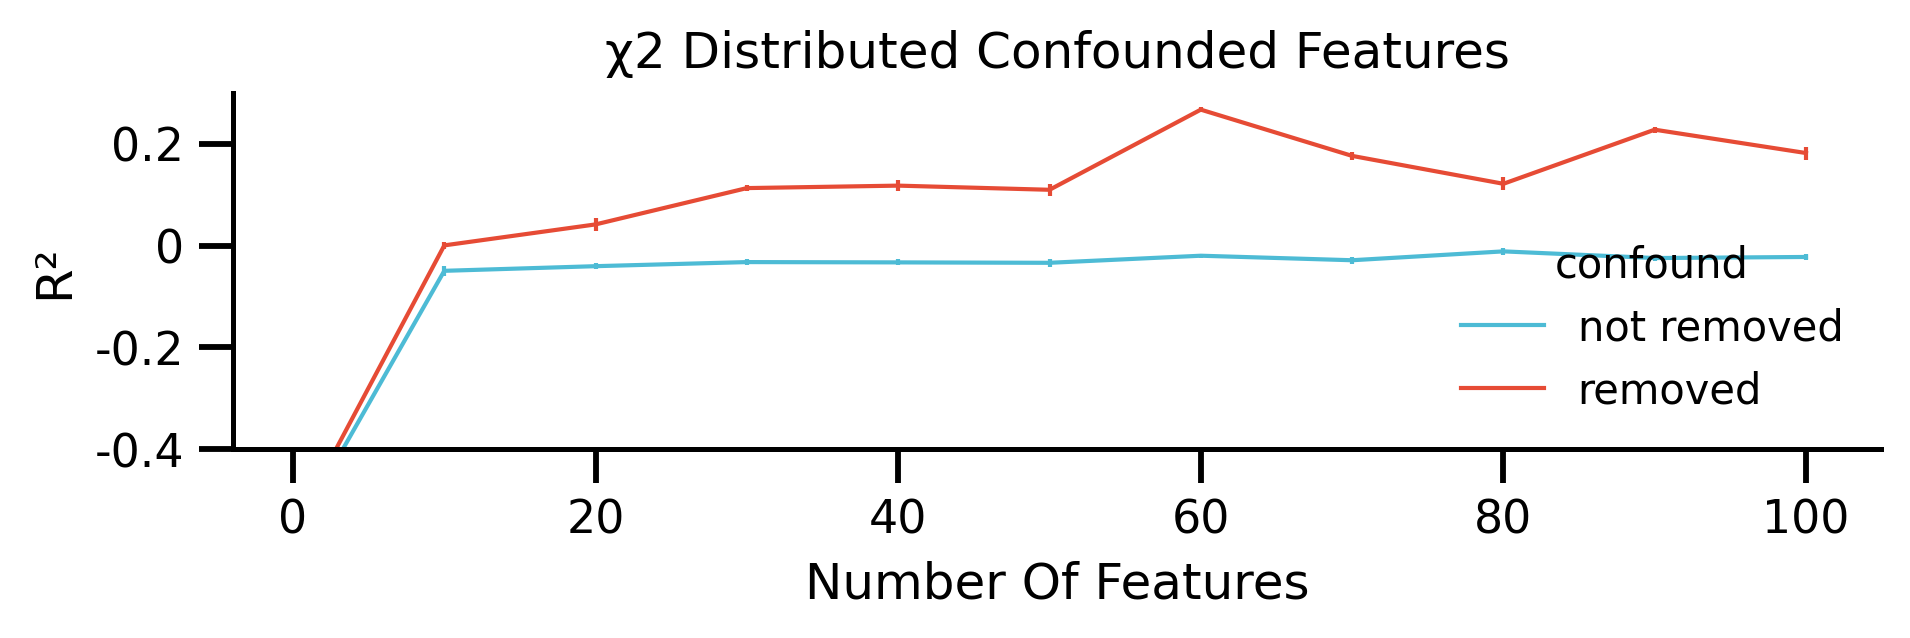

In [3]:
df_rem = pd.DataFrame(
    dict(scores=all_scores_rem, iteration=feat_nbr, yerr=all_yerr_rem)
)
df_rem["remove confounds"] = "confound removed"
df_no_rem = pd.DataFrame(
    dict(scores=all_scores_raw, iteration=feat_nbr, yerr=all_yerr_raw)
)
df_no_rem["remove confounds"] = "no removal"

df_plot = pd.concat([df_rem, df_no_rem])

df_plot["confound"] = df_plot["remove confounds"].apply(
    lambda x: ("removed" if x == "confound removed" else "not removed")
)
fig, ax = plt.subplots(figsize=[mm_to_inch(180), mm_to_inch(40)])
g = sns.lineplot(
    x="iteration",
    y="scores",
    hue="confound",
    hue_order=["not removed", "removed"],
    data=df_plot.reset_index(),
    palette=sns.color_palette([blue, red]),
    ax=ax,
)
g.set(
    xlabel="Number Of Features", ylabel="R²", title="χ2 Distributed Confounded Features"
)

df_plot_removed = df_plot.query('confound=="removed"')
ax.errorbar(
    df_plot_removed["iteration"],
    df_plot_removed["scores"],
    df_plot_removed["yerr"],
    fmt="none",
    color=red,
)

df_plot_not_removed = df_plot.query('confound=="not removed"')
ax.errorbar(
    df_plot_not_removed["iteration"],
    df_plot_not_removed["scores"],
    df_plot_not_removed["yerr"],
    fmt="none",
    color=blue,
)
ax.yaxis.set_major_locator(mpl.ticker.FixedLocator([-0.4, -0.2, 0, 0.2]))

ax.yaxis.set_major_formatter(mpl.ticker.FixedFormatter([-0.4, -0.2, 0, 0.2]))

ax.set_ylim(-0.4, 0.3)

In [4]:
fig.savefig("./saved_figures/extra_sim_added_feat.png")
fig.savefig("./saved_figures/extra_sim_added_feat.svg")